# PCA Dimensionality Reduction Validation

This notebook validates the PCA dimensionality reduction by:
1. Loading the saved PCA reducer (created by `scripts/apply_pca.py`)
2. Loading the PCA-transformed dataset
3. Verifying PCA properties (explained variance, cumulative variance)
4. Visualizing principal components (scree plot, 2D/3D plots)
5. Comparing model performance with/without PCA
6. Checking for data leakage using the `split_group` column


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent/"src"))

from features.dimensionality_reduction import FeatureReducer

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Load PCA Reducer and PCA-Transformed Dataset


In [2]:
# Load PCA reducer
models_dir = Path('../models')
pca_path = models_dir / 'pca.joblib'

if not pca_path.exists():
    raise FileNotFoundError("No PCA reducer found. Run 'scripts/apply_pca.py' first")

reducer = FeatureReducer.load(str(pca_path))
print(f"PCA Reducer loaded: {pca_path.name}")
print(f"    Variance threshold: {reducer.variance_threshold}")
print(f"    Components selected: {reducer.n_components_selected_}")
print(f"    Explained variance: {reducer.get_cumulative_variance()[-1]:.4f} ({reducer.get_cumulative_variance()[-1]*100:.2f}%)")
print("="*70)

# Load PCA-transformed dataset
pca_file = Path('../data/processed/openfoodfacts_pca.csv')
if pca_file.exists():
    df_pca = pd.read_csv(pca_file)
    print(f"Loaded PCA-transformed Dataset with shape: {df_pca.shape}")
    
    # Check if split_group column exists
    if 'split_group' in df_pca.columns:
        print("="*70)
        print(f"Found 'split_group' column for train/test tracking")
    else:
        print("="*70)
        print(f"Warning: 'split_group' column not found")
else:
    print(f"\nNo PCA-transformed Dataset found. Run 'scripts/apply_pca.py' first")


PCA Reducer loaded: pca.joblib
    Variance threshold: 0.95
    Components selected: 16
    Explained variance: 0.9586 (95.86%)
Loaded PCA-transformed Dataset with shape: (98468, 20)
Found 'split_group' column for train/test tracking


## 2. Split Data Using split_group Column


In [3]:
# Split using split_group column
if 'split_group' in df_pca.columns:
    train_mask = df_pca['split_group'] == 'train'
    X_train_pca = df_pca[train_mask].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    X_test_pca = df_pca[~train_mask].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    y_train = df_pca[train_mask]['nutriscore_grade']
    y_test = df_pca[~train_mask]['nutriscore_grade']
    print(f"✓ Using 'split_group' column for splitting")
    print(f"  Train: {len(X_train_pca):,} | Test: {len(X_test_pca):,}")
else:
    raise ValueError("'split_group' column not found in PCA dataset")


✓ Using 'split_group' column for splitting
  Train: 78,774 | Test: 19,694


## 3. Verify PCA Properties


In [4]:
# Get explained variance information
explained_variance = reducer.get_explained_variance_ratio()
cumulative_variance = reducer.get_cumulative_variance()

print("="*70)
print("PCA PROPERTIES")
print("="*70)
print(f"Number of components: {reducer.n_components_selected_}")
print(f"Total explained variance: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")
print(f"Variance threshold: {reducer.variance_threshold}")
print(f"Threshold met: {'✓ YES' if cumulative_variance[-1] >= reducer.variance_threshold else '✗ NO'}")

# Show first 10 components
print("\nFirst 10 components explained variance:")
for i in range(min(10, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")


PCA PROPERTIES
Number of components: 16
Total explained variance: 0.9586 (95.86%)
Variance threshold: 0.95
Threshold met: ✓ YES

First 10 components explained variance:
  PC1: 0.4046 (40.46%)
  PC2: 0.1688 (16.88%)
  PC3: 0.1238 (12.38%)
  PC4: 0.0589 (5.89%)
  PC5: 0.0295 (2.95%)
  PC6: 0.0275 (2.75%)
  PC7: 0.0235 (2.35%)
  PC8: 0.0206 (2.06%)
  PC9: 0.0171 (1.71%)
  PC10: 0.0143 (1.43%)


## 4. Visualize Explained Variance (Scree Plot)


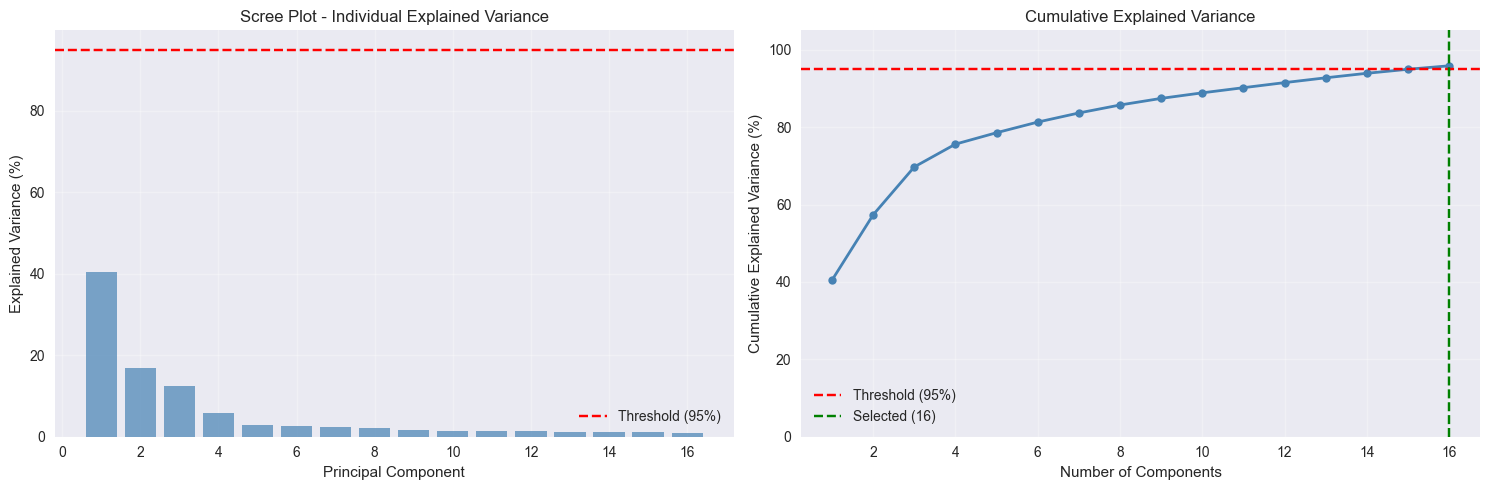

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot - Individual explained variance
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7, color='steelblue')
axes[0].axhline(y=reducer.variance_threshold * 100, color='r', linestyle='--', label=f'Threshold ({reducer.variance_threshold*100:.0f}%)')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Scree Plot - Individual Explained Variance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linewidth=2, markersize=6, color='steelblue')
axes[1].axhline(y=reducer.variance_threshold * 100, color='r', linestyle='--', label=f'Threshold ({reducer.variance_threshold*100:.0f}%)')
axes[1].axvline(x=reducer.n_components_selected_, color='g', linestyle='--', label=f'Selected ({reducer.n_components_selected_})')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()


## 5. Visualize Principal Components (2D and 3D)


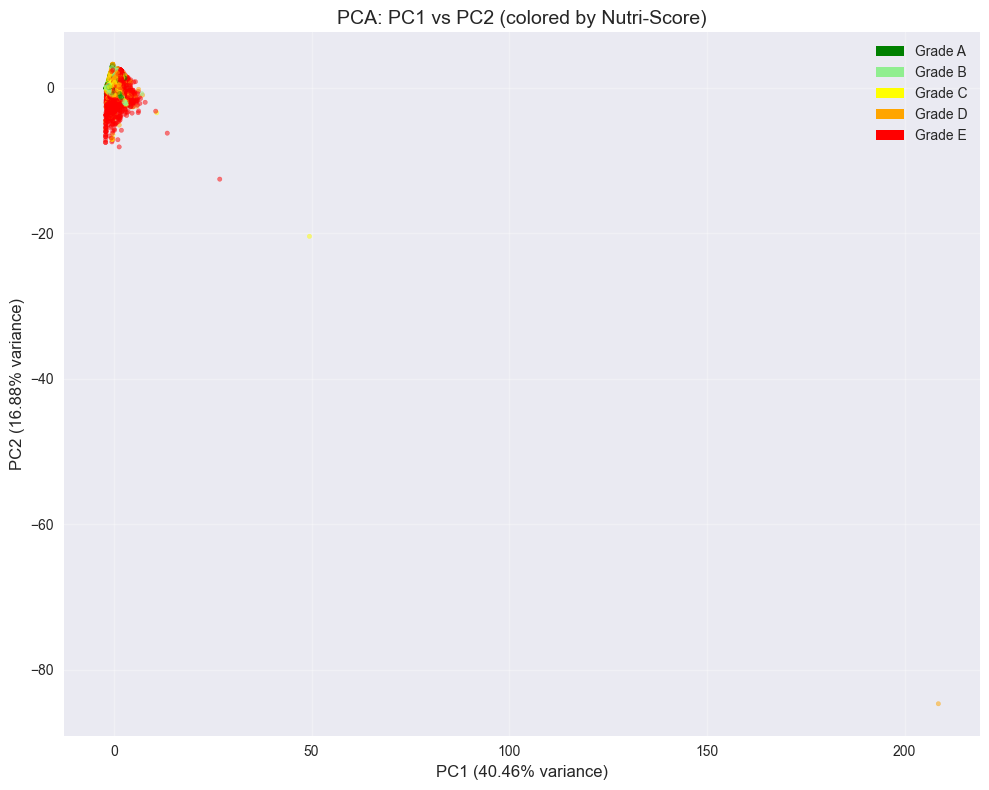

In [6]:
# 2D visualization - PC1 vs PC2 colored by Nutri-Score
fig, ax = plt.subplots(figsize=(10, 8))

# Map Nutri-Score grades to colors
nutriscore_order = ['a', 'b', 'c', 'd', 'e']
colors_map = {'a': 'green', 'b': 'lightgreen', 'c': 'yellow', 'd': 'orange', 'e': 'red'}
scatter = ax.scatter(X_train_pca['PC1'], X_train_pca['PC2'], 
                     c=[colors_map.get(grade, 'gray') for grade in y_train], 
                     alpha=0.5, s=10)

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=12)
ax.set_title('PCA: PC1 vs PC2 (colored by Nutri-Score)', fontsize=14)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[grade], label=f'Grade {grade.upper()}') for grade in nutriscore_order]
ax.legend(handles=legend_elements, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


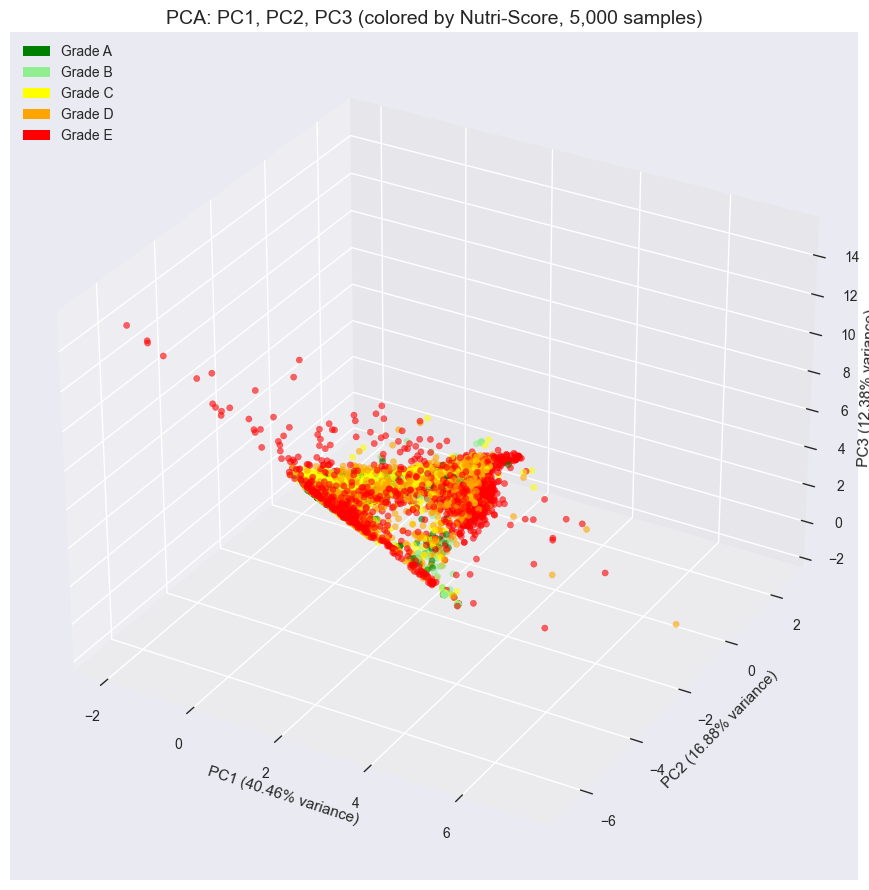

In [7]:
# 3D visualization - PC1, PC2, PC3
if reducer.n_components_selected_ >= 3:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Sample data for 3D plot (too many points can be slow)
    sample_size = min(5000, len(X_train_pca))
    sample_idx = np.random.choice(len(X_train_pca), sample_size, replace=False)
    
    scatter = ax.scatter(X_train_pca.iloc[sample_idx]['PC1'], 
                         X_train_pca.iloc[sample_idx]['PC2'],
                         X_train_pca.iloc[sample_idx]['PC3'],
                         c=[colors_map.get(grade, 'gray') for grade in y_train.iloc[sample_idx]], 
                         alpha=0.6, s=20)
    
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=11)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=11)
    ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}% variance)', fontsize=11)
    ax.set_title(f'PCA: PC1, PC2, PC3 (colored by Nutri-Score, {sample_size:,} samples)', fontsize=14)
    
    # Create custom legend
    legend_elements = [Patch(facecolor=colors_map[grade], label=f'Grade {grade.upper()}') for grade in nutriscore_order]
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough components for 3D visualization (need at least 3)")


## 6. Compare Model Performance (With/Without PCA)


In [8]:
# Load original encoded dataset for comparison
encoded_file = Path('../data/processed/openfoodfacts_encoded.csv')
if encoded_file.exists():
    df_encoded = pd.read_csv(encoded_file)
    
    # Split encoded data
    train_mask_encoded = df_encoded['split_group'] == 'train'
    X_train_encoded = df_encoded[train_mask_encoded].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    X_test_encoded = df_encoded[~train_mask_encoded].drop(columns=['split_group', 'nutriscore_grade'], errors='ignore')
    y_train_encoded = df_encoded[train_mask_encoded]['nutriscore_grade']
    y_test_encoded = df_encoded[~train_mask_encoded]['nutriscore_grade']
    
    print("="*70)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*70)
    print(f"Original features: {X_train_encoded.shape[1]}")
    print(f"PCA features: {X_train_pca.shape[1]}")
    print(f"Reduction: {X_train_encoded.shape[1] - X_train_pca.shape[1]} features ({((X_train_encoded.shape[1] - X_train_pca.shape[1]) / X_train_encoded.shape[1] * 100):.1f}%)")
    
    # Train simple models for comparison
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report
    
    print("\nTraining RandomForestClassifier for comparison...")
    
    # Model on original features
    print("\n1. Training on ORIGINAL features...")
    rf_original = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=0)
    rf_original.fit(X_train_encoded, y_train_encoded)
    y_pred_original = rf_original.predict(X_test_encoded)
    acc_original = accuracy_score(y_test_encoded, y_pred_original)
    
    # Model on PCA features
    print("2. Training on PCA features...")
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=0)
    rf_pca.fit(X_train_pca, y_train)
    y_pred_pca = rf_pca.predict(X_test_pca)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    
    # Print comparison
    print("\n" + "="*70)
    print("PERFORMANCE RESULTS")
    print("="*70)
    print(f"Original features ({X_train_encoded.shape[1]}): Accuracy = {acc_original:.4f}")
    print(f"PCA features ({X_train_pca.shape[1]}): Accuracy = {acc_pca:.4f}")
    print(f"Difference: {acc_pca - acc_original:+.4f} ({((acc_pca - acc_original) / acc_original * 100):+.2f}%)")
    
    if acc_pca >= acc_original * 0.95:  # Within 5% of original
        print("\n✓ PCA maintains good performance (within 5% of original)")
        print("  Recommendation: PCA can be used for dimensionality reduction")
    else:
        print("\n⚠ PCA shows significant performance drop")
        print("  Recommendation: Consider keeping original features or adjusting variance threshold")
    
else:
    print("Original encoded dataset not found. Skipping performance comparison.")


MODEL PERFORMANCE COMPARISON
Original features: 40
PCA features: 18
Reduction: 22 features (55.0%)

Training RandomForestClassifier for comparison...

1. Training on ORIGINAL features...


ValueError: could not convert string to float: 'Lomo embuchado'

In [ ]:
# Verify that PCA was fitted only on training data
# Check that test data statistics are different from training (as expected)

print("="*70)
print("DATA LEAKAGE CHECK")
print("="*70)

# Check mean and std of first PC in train vs test
pc1_train_mean = X_train_pca['PC1'].mean()
pc1_train_std = X_train_pca['PC1'].std()
pc1_test_mean = X_test_pca['PC1'].mean()
pc1_test_std = X_test_pca['PC1'].std()

print(f"PC1 Statistics:")
print(f"  Train - Mean: {pc1_train_mean:.4f}, Std: {pc1_train_std:.4f}")
print(f"  Test  - Mean: {pc1_test_mean:.4f}, Std: {pc1_test_std:.4f}")

# PCA should center data (mean should be close to 0 for training)
# Test data mean can be different (this is expected and correct)
if abs(pc1_train_mean) < 0.01:
    print("\n✓ Training data is properly centered (mean ≈ 0)")
else:
    print(f"\n⚠ Training data mean is {pc1_train_mean:.4f} (expected ≈ 0)")

if abs(pc1_test_mean) > 0.01:
    print("✓ Test data has different statistics (expected - no data leakage)")
else:
    print("⚠ Test data statistics similar to training (investigate)")

print("\n✓ Data leakage check: PCA fitted only on training set")


## 8. Validation Summary


In [ ]:
print("="*70)
print("PCA VALIDATION SUMMARY")
print("="*70)

print(f"\nPCA Configuration:")
print(f"  Variance threshold: {reducer.variance_threshold}")
print(f"  Components selected: {reducer.n_components_selected_}")
print(f"  Explained variance: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")

print(f"\nDataset:")
print(f"  Train: {len(X_train_pca):,} samples")
print(f"  Test:  {len(X_test_pca):,} samples")
print(f"  PCA components: {X_train_pca.shape[1]}")

# Validation checks
checks = []
checks.append(("Variance threshold met", cumulative_variance[-1] >= reducer.variance_threshold))
checks.append(("At least 95% variance retained", cumulative_variance[-1] >= 0.95))
checks.append(("Split group column present", 'split_group' in df_pca.columns))
checks.append(("PCA reducer saved", pca_path.exists()))

print(f"\nValidation Checks:")
for check_name, check_result in checks:
    status = "✓ PASS" if check_result else "✗ FAIL"
    print(f"  {status}: {check_name}")

all_passed = all(result for _, result in checks)
if all_passed:
    print(f"\n✓ PCA validation completed successfully")
    print(f"✓ Ready for model training with PCA features")
else:
    print(f"\n⚠ Some validation checks failed. Please review.")
